# Smoothing with Wave Transform Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
p = print

from os.path import join
import gc
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
import pywt

from crypr.util import get_project_path
from crypr.build import make_single_feature, data_to_supervised, dwt_smoother

In [2]:
SYM = 'BTC'
TARGET = 'close'
Tx = 72
Ty = 1
TEST_SIZE = 0.05
data_path = join(get_project_path(), 'data', 'raw', SYM + '.csv')

In [3]:
data = pd.read_csv(data_path, index_col=0)
data.head()

,volumeto,volumefrom,open,high,close,low,time,timestamp
0,10630764.80,1704.06,6177.53,6188.18,6183.09,6160.27,1531422000,2018-07-12 21:00:00
1,8563525.07,1370.22,6183.09,6192.99,6184.27,6177.94,1531425600,2018-07-12 22:00:00
2,8029608.45,1293.66,6184.27,6185.31,6175.03,6163.74,1531429200,2018-07-12 23:00:00
3,12961149.43,2096.36,6175.11,6182.18,6157.64,6133.93,1531432800,2018-07-13 00:00:00
4,53620136.26,8660.90,6157.64,6270.29,6253.60,6084.00,1531436400,2018-07-13 01:00:00


In [4]:
"""
Get percent change feature and target data.
"""
df = make_single_feature(input_df=data, target_col='close')
X, y = data_to_supervised(input_df=df[['target']], Tx=Tx, Ty=Ty)
p(X.shape, y.shape)
X.head()

(5926, 72) (5926, 1)


,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
73,0.019084,-0.149411,-0.281618,1.558389,-0.042855,-0.264921,0.168261,0.123942,0.082366,-0.027326,...,0.512280,0.226730,-0.286384,0.351958,-0.155110,0.447812,0.148397,-0.051424,-0.650092,0.376520
74,-0.149411,-0.281618,1.558389,-0.042855,-0.264921,0.168261,0.123942,0.082366,-0.027326,-0.139705,...,0.226730,-0.286384,0.351958,-0.155110,0.447812,0.148397,-0.051424,-0.650092,0.376520,0.261886
75,-0.281618,1.558389,-0.042855,-0.264921,0.168261,0.123942,0.082366,-0.027326,-0.139705,0.072832,...,-0.286384,0.351958,-0.155110,0.447812,0.148397,-0.051424,-0.650092,0.376520,0.261886,-0.079455
76,1.558389,-0.042855,-0.264921,0.168261,0.123942,0.082366,-0.027326,-0.139705,0.072832,0.000640,...,0.351958,-0.155110,0.447812,0.148397,-0.051424,-0.650092,0.376520,0.261886,-0.079455,-0.091415
77,-0.042855,-0.264921,0.168261,0.123942,0.082366,-0.027326,-0.139705,0.072832,0.000640,-0.076137,...,-0.155110,0.447812,0.148397,-0.051424,-0.650092,0.376520,0.261886,-0.079455,-0.091415,-0.287500


In [5]:
"""
Confirm data reshape and target/feature creation was done correctly.
"""
y_values_except_last = np.squeeze(y.iloc[:-1].values)
t_minus_1_x_values_except_first = X.iloc[1:,-1].values

y_values_except_last.all() == t_minus_1_x_values_except_first.all()

True

In [6]:
"""
For comparing different transformations
"""
sample_ix = 1000
sample = X.iloc[sample_ix].values

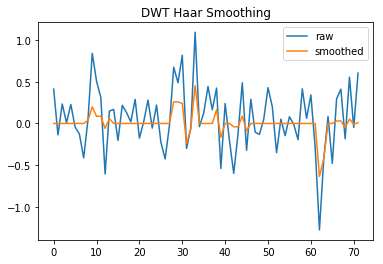

In [7]:
"""
DWT Haar Transform
"""
smoothed_sample = dwt_smoother(sample, 'haar', smooth_factor=.4)
plt.plot(sample, label='raw')
plt.plot(smoothed_sample, label='smoothed')
plt.title('DWT Haar Smoothing')
plt.legend()
plt.show()

In [8]:
"""
Apply the wavelet transformation smoothing to the feature data.
"""
wt_type = 'haar'
smoothing = .4
X_smooth = np.apply_along_axis(func1d=lambda x: dwt_smoother(x, wt_type, smooth_factor=smoothing), 
                               axis=-1, arr=X)

assert X_smooth.shape == X.shape

In [9]:
"""
Train Test Split.
"""
X_train, X_test, y_train, y_test = train_test_split(X_smooth, y, test_size=TEST_SIZE, shuffle=False)

In [10]:
# """
# Save data.
# """
# np.save(arr=X_train, file='../data/processed/X_train_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
# np.save(arr=X_test,  file='../data/processed/X_test_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
# np.save(arr=y_train, file='../data/processed/y_train_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))
# np.save(arr=y_test,  file='../data/processed/y_test_{}_{}_smooth_{}'.format(SYM, wt_type, Tx))